# Metrics III - Exercise class 2

This notebook contains the coding material for the second TA-session of the PhD core course Statistics and Econometrics 3, part 1 (EUI, 2025). 

*Any errors are my own, in case of conflicts always follow the [course material](https://jesusbueren.github.io/teaching/)
 provided.*

Questions can be asked during TA-sessions, office hours, or by email. 

**TA-Sessions**

- 07-02-2025 at 14:00
- 12-02-2025 at 14:00
- 20-02-2025 at 14:00

**Office hours**

- Tuesday 18-02; 09:00-11:00

**PS submission guidelines + general remarks**

Please submit **one** file, containing text, code, calculations. (Think RMarkdown, Jupyter Notebook, Overleaf with minted environment appendix with code).

Try to code from scratch, and not to use built-in functions. Try to write your own functions. 

In [1]:
# SET-UP
library(tidyverse)
library(ggplot2)

options(warn=-1)

set.seed(42)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


## Exercise 1

Let's again use the AR(1) process to illustrate the different parts of the exercise: $y_t = 0.7 y_{t-1} + u_t$

In [2]:
# Simulate data: 
phi <- 0.7
window <- 500
y0 <- 0

# Initialize empty data frame up to window T
df <- data.frame(
  "y" = c(y0, rep(0, window)), # add initial value, y_{-1}
  "u_t" = c(0, rnorm(n=window, mean=0, sd=1)) 
)

# Loop over the window period to get the simulated series: 
for (i in 2:(window+1)){
  
  df[i, "y"] <- phi*df[i-1, "y"] + df[i, "u_t"]
  
}

# Tidy
df <- df[-1, ]
df <- df%>%mutate(time = row_number())

### Conditional MLE

The goal is to estimate the vector of population parameters $\theta$. In our case $\theta = \{\phi_1, \sigma^2 \}$. We also have a vector of initial values $y_p$, which in our case also just consists of one observation. 

We then re-write the AR(1) for the error term: $\epsilon_t = y_t - \phi_1 y_{t-1}$. 

Since we know the errors follow a normal distribution, we can use this in our MLE. As usual, we take the log, which gives the likelihood function: 

\begin{align}
L(\theta) &= -\frac{T}{2} \log(2\pi) - \frac{T}{2} \log(\sigma^2_{\varepsilon}) 
- \sum_{t=1}^{T} \frac{\varepsilon_t^2}{2\sigma^2_{\varepsilon}}
\end{align}

To implement the estimation, we have multiple options: 

- Grid search (EXAMPLE)
- Solver (USED AS EXAMPLE)
- Root finders

#### Solver

In [3]:
# Function to implement the MLE 
mle <- function(params, data){
  
  phi <- params[[1]] # unpack parameters
  sigmas <- params[[2]]
  
  time <- nrow(data)
  res <- vector()
  
  for(i in (2:time)){
    res[i] = data[i, "y"] - phi*data[i-1, "y"] # re-write in the error terms
  }
  
  residual <- res[-1]
  
  loglikelihood <- (-1*((time-1)/2)*log(pi*2)) -  (((time-1)/2)*log(sigmas)) - sum((residual**2)/(2*sigmas)) 
  
  return(loglikelihood)
  
}

# Find the minimum values using an optimizer
params <- c(0, 2) # start sigma far enough from 0 (log(0) gives -inf)

minim_mle <- optim(fn=mle, par=params, method="BFGS", hessian = T, control=list(fnscale=-1), data = df)

phi_hat <- minim_mle$par[[1]]
sigmas_hat <- minim_mle$par[[2]]

print(glue::glue("The true population parameter was phi = 0.7, the estimated one is {round(phi_hat, 5)}"))
print(glue::glue("The true population parameter was sigma^2 = 1, the estimated one is {round(sigmas_hat, 5)}"))

The true population parameter was phi = 0.7, the estimated one is 0.67471
The true population parameter was sigma^2 = 1, the estimated one is 0.94116


#### Grid search

Instead of using an optimizer, we can also take a bit more of a brute force approach. We select a grid of possible values, and calculate the log likelihood for each of the combinations of these parameter values. 

We then select the value with the maximum loglikelihood. As a rule of thumb it is of course important to check that the solution is not a corner point of your grid. In this well-defined optimization problem we expect to find an interior solution. If your grid search provides you with a corner solution for one of the parameters, you would want to double check by expanding your grid. 

In [4]:
# Grids to be checked
grid_s <- seq(from = -1, to = 2, by = 0.1)
grid_f <- seq(from = 0, to = 1, by = 0.1)

# Fix that sigma^2 is not 0, because of the log
grid_s[grid_s == 0] <- 0.0001

# Extract all combinations in a data frame
combs <- expand.grid("phi" = grid_f, "sigma" = grid_s) 

# Calculate log likelihood for all 
combs$loglikelihood <- apply(combs, 1, function(row) mle(as.numeric(row), data = df))

# Max negative log likelihood: 
combs%>%filter(loglikelihood == max(loglikelihood, na.rm = TRUE))

# What about the true population one?? Why do we not get the LL at those of the DGP
combs%>%filter(
  near(0.7, phi), 
  sigma > 0.7, 
  sigma < 1.2
  )

# Darn samples!!!

phi,sigma,loglikelihood
<dbl>,<dbl>,<dbl>
0.7,0.9,-693.4807


phi,sigma,loglikelihood
<dbl>,<dbl>,<dbl>
0.7,0.7,-705.4115
0.7,0.8,-696.7461
0.7,0.9,-693.4807
0.7,1.0,-693.6464
0.7,1.1,-696.0539


### Computing information criteria

Using the value of the loglikelihood found in the first part, we can calculate the information criteria. Using the formulas of the slides: 

In [5]:
# Information needed
k <- 2 # number of estimated params in theta vector: (k = p + q + 1)
time <- 499 

# Retrieve loglikelihood: 
ll <- minim_mle$value

# Note that we were minimizing in the function, so to get correct AIC + BIC, multiply by -1
print(ll) # note negative!

# AIC
 aic <- 2 * k - (2 * ll)
print(paste0("AIC is : ", aic))

# BIC
bic <-  log(time) * k - (2 * ll)
print(paste0("BIC is : ", bic))

[1] -692.92
[1] "AIC is : 1389.839942826"
[1] "BIC is : 1398.26515501751"


## Appendix

### Conditional MLE and OLS equivalence

According to slide 12 of Ch3 of the slides, we can find $\hat{\beta}$ also using OLS. Specifically, conditional MLE and OLS should give exactly the same solution. So let's check:

In [7]:
# Add lagged value of y to the data
df <- df%>%
  mutate(lag_y = lag(y, n=1))%>%
  slice_tail(n=-1)

# MLE one
print(paste0("beta_hat of conditional MLE was: ", phi_hat))

# Using LM we get: 
mod <- lm(y ~ lag_y, data = df)
print(paste0("OLS coefficients using built-in function"))
summary(mod)

# OLS estimator for beta using partialling out [Metrics 1]
beta_hat <- solve(t(df$lag_y) %*% df$lag_y) %*% t(df$lag_y) %*% df$y
print(paste0("Estimated beta hat using partialling out: ", beta_hat))

# AIC/BIC (manually adjust k argument! check ?AIC)
AIC(mod)
BIC(mod) 

[1] "beta_hat of conditional MLE was: 0.674709949776257"
[1] "OLS coefficients using built-in function"



Call:
lm(formula = y ~ lag_y, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.92898 -0.65006 -0.02003  0.65634  3.04134 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.03452    0.04370   -0.79     0.43    
lag_y        0.67350    0.03318   20.30   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9722 on 496 degrees of freedom
Multiple R-squared:  0.4537,	Adjusted R-squared:  0.4526 
F-statistic:   412 on 1 and 496 DF,  p-value: < 2.2e-16


[1] "Estimated beta hat using partialling out: 0.675551240527199"


[1] 1389.137

[1] 1401.769

So where do the small discrepancies between the built in function and the conditional MLE come from? 

This is a good illustration of why it is important to understand what built-in functions do. And what the impact is of using a sample and not the population. The linear model estimates the coefficient by default using a model with an intercept. Our true DGP does not feature an intercept. This is equivalent to $c = 0$. However, the estimated intercept $\hat{c} \neq 0$, meaning that the $\hat{\beta}$ is slightly different. 

### Numerical VCOV matrix

You can also use multivariate first differences to numerically approximate the Hessian. See the formulas from [Wikipedia](https://en.wikipedia.org/wiki/Finite_difference). 

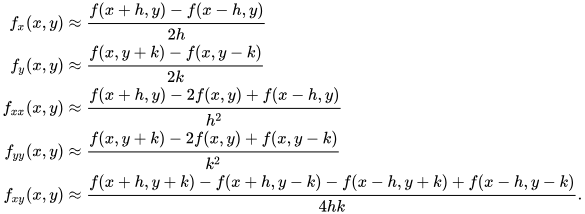

The `Optim` function also gives us a Hessian matrix, so let's compare: 

**(If you spot why the off-diagonal terms are not the same, let me know. Seems a little computation mistake there... :))**

In [8]:
# Optim's version:
H<-solve(-minim_mle$hessian)
sqrt(diag(H))

[1] 0.03297526 0.05958341

In [9]:
# Implementation from scratch:
numerical_hessian <- function(f, params, data, epsilon = 1e-5) {
  
  x <- params[1]
  y <- params[2]
  
  f_xx <- (f(c(x + epsilon, y), data) - 2 * f(c(x, y), data) +  f(c(x - epsilon, y), data)) / epsilon^2
  f_yy <- (f(c(x, y + epsilon), data) - 2 * f(c(x, y), data) +  f(c(x, y - epsilon), data)) / epsilon^2
  f_xy <- (f(c(x + epsilon, y + epsilon), data) - f(c(x + epsilon, y - epsilon), data) - f(c(x - epsilon, y + epsilon), data) +  f(c(x - epsilon, y - epsilon), data)) / 4*epsilon^2
  
  hessian_matrix <- rbind(c(f_xx, f_xy), c(f_xy, f_yy)) # This is assuming symmetry: f_xy=f_yx
  
  return(hessian_matrix)
}

# Estimate Hessian at initial parameter values
params_opt <- c(minim_mle$par[[1]], minim_mle$par[[2]]) # Initial guess for phi and sigma^2
Hessian <- numerical_hessian(mle, params_opt, df, epsilon=0.01)

H_num <- solve(-Hessian)
sqrt(diag(H_num))

[1] 0.03301410 0.05951259